# EDA

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

Index is set as `data_block_id` because it shows the data structure for inference.

In [2]:
data_dict = {}

data_dict["client"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/client.csv",
    parse_dates=["date"],
)
data_dict["electricity_prices"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/electricity_prices.csv",
    parse_dates=["forecast_date", "origin_date"],
)
data_dict["forecast_weather"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/forecast_weather.csv",
    parse_dates=["forecast_datetime", "origin_datetime"],
)
data_dict["gas_prices"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/gas_prices.csv",
    parse_dates=["forecast_date", "origin_date"],
)
data_dict["historical_weather"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/historical_weather.csv",
    parse_dates=["datetime"],
)
data_dict["train"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/train.csv",
    parse_dates=["datetime"],
)
data_dict["weather_station_to_county_mapping"] = pd.read_csv(
    "predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv"
)

In [3]:
data_dict["train"].head(
    123
)  # 123 has been chosen to show full datetime column instead of only the date by default when all values shown are at 00:00:00

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
118,15,1,1,0.100,0,2021-09-01 00:00:00,0,118,59
119,15,1,1,17.703,1,2021-09-01 00:00:00,0,119,59
120,15,1,3,0.000,0,2021-09-01 00:00:00,0,120,60
121,15,1,3,289.159,1,2021-09-01 00:00:00,0,121,60


### Missing values

Missing values:
- Forecast weather `surface_solar_radiation_downwards` has 2
- train `target` has 528

In [4]:
print("============================== client.csv ==============================")
print(data_dict["client"].isna().sum())

print("\n======================== electricity_prices.csv ========================")
print(data_dict["electricity_prices"].isna().sum())

print("\n========================= forecast_weather.csv =========================")
print(data_dict["forecast_weather"].isna().sum())

print("\n============================ gas_prices.csv ============================")
print(data_dict["gas_prices"].isna().sum())

print("\n======================== historical_weather.csv ========================")
print(data_dict["historical_weather"].isna().sum())

print("\n=============================== train.csv ===============================")
print(data_dict["train"].isna().sum())

============================== client.csv ==============================
product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

======================== electricity_prices.csv ========================
forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

========================= forecast_weather.csv =========================
latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
fo

#### Train missing values

Missing values appear to be missing during DST changes. Since data is provided hourly, Enefit's system might have recorded either none target consumption at 3.00 am when DST starts or 2 values when DST ends, which could probably result in NA values.

In [5]:
train = data_dict["train"].copy()
train[train["target"].isna()]["datetime"].value_counts().sort_index()

datetime
2021-10-31 03:00:00    126
2022-03-27 03:00:00    134
2022-10-30 03:00:00    136
2023-03-26 03:00:00    132
Name: count, dtype: int64

By displaying the NA values in context, we can assume to fill them with interpolated values from surrounding hours.

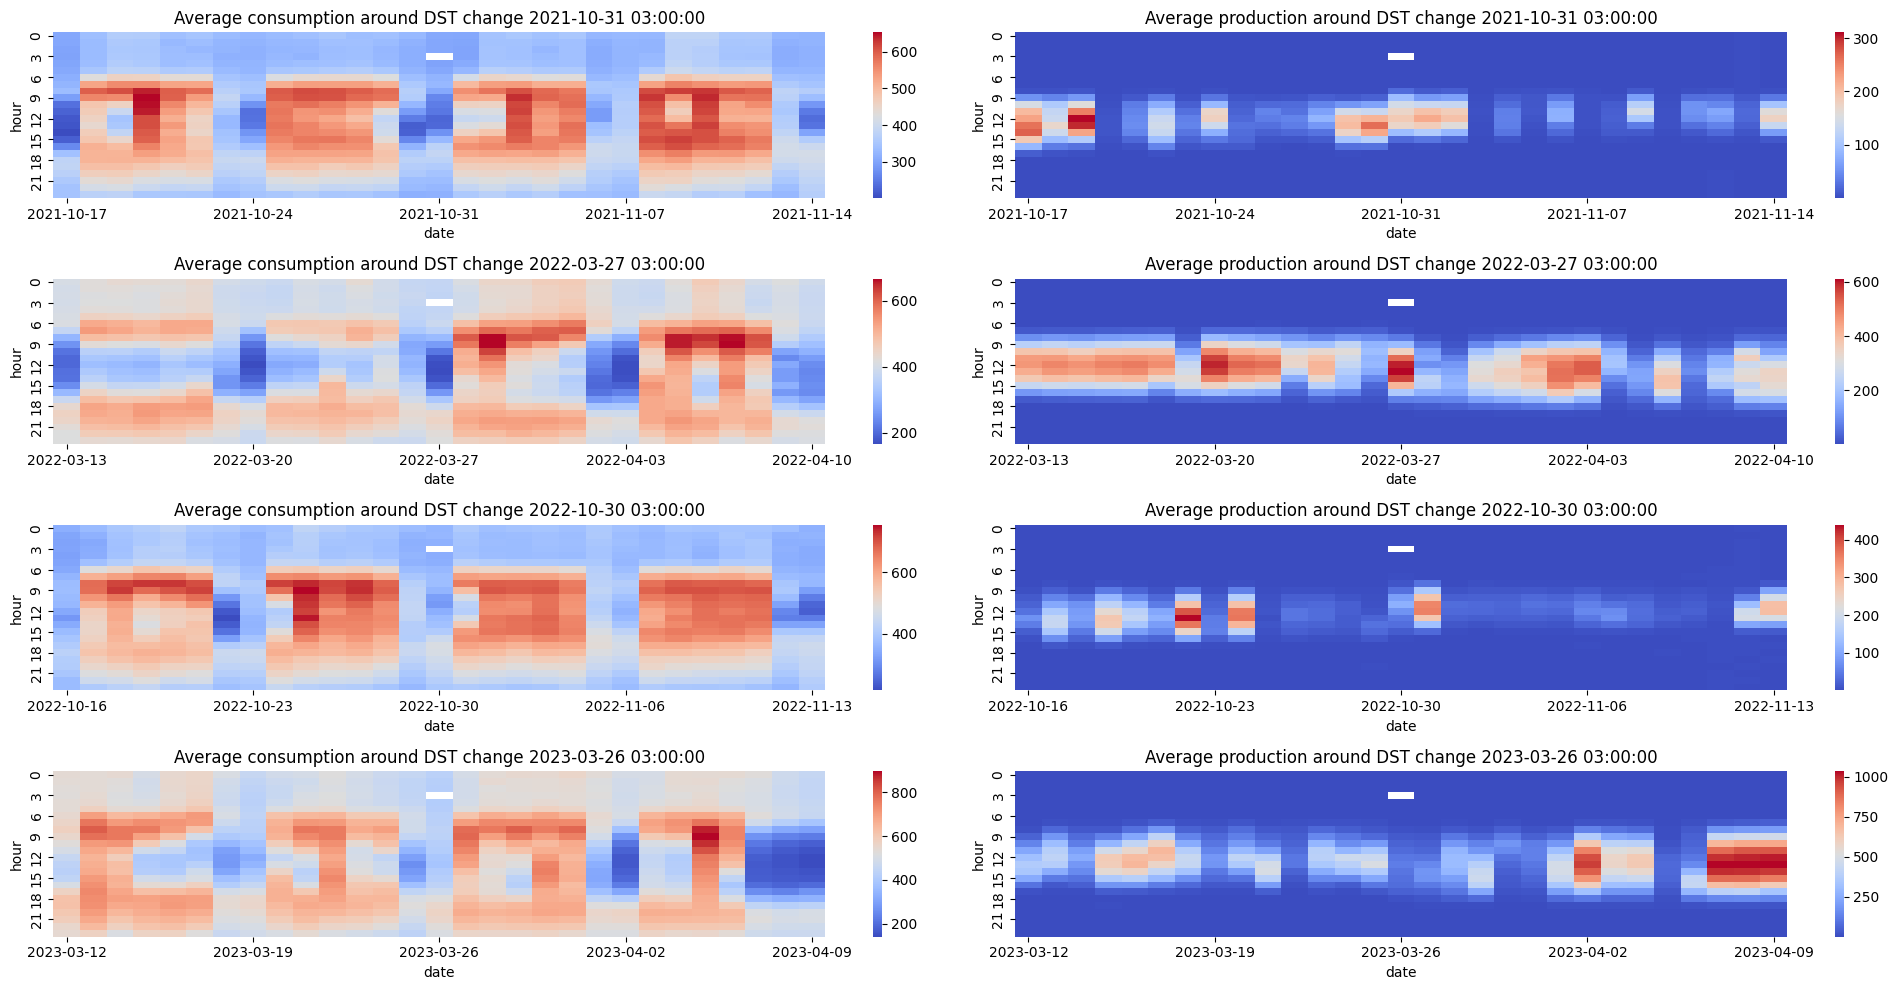

In [6]:
dst_datetimes = train[train["target"].isna()]["datetime"].unique()
fig, ax = plt.subplots(len(dst_datetimes), 2, figsize=(20, 10))
for i, dst_datetime in enumerate(dst_datetimes):
    dst_analysis = train[
        (train["datetime"] >= dst_datetime - pd.Timedelta(weeks=2, hours=3))
        & (train["datetime"] <= dst_datetime + pd.Timedelta(weeks=2, hours=20))
    ].copy()
    dst_analysis["hour"] = dst_analysis["datetime"].dt.hour
    dst_analysis["date"] = dst_analysis["datetime"].dt.date

    consumption_target = dst_analysis[dst_analysis["is_consumption"] == 1].pivot_table(
        index="hour", columns="date", values="target", aggfunc="mean"
    )
    production_target = dst_analysis[dst_analysis["is_consumption"] == 0].pivot_table(
        index="hour", columns="date", values="target", aggfunc="mean"
    )

    sns.heatmap(consumption_target, cmap="coolwarm", ax=ax[i, 0], xticklabels=7)
    sns.heatmap(production_target, cmap="coolwarm", ax=ax[i, 1], xticklabels=7)
    ax[i, 0].set_title(f"Average consumption around DST change {dst_datetime}")
    ax[i, 1].set_title(f"Average production around DST change {dst_datetime}")
plt.tight_layout()

#### Forecast weather missing values

Might be a technical error at random but the missing values are located in the sea so they will be filtered out when locating weather to the counties.

In [7]:
forecast_weather = data_dict["forecast_weather"].copy()
forecast_weather[forecast_weather["surface_solar_radiation_downwards"].isna()]

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
1849670,59.7,23.7,2022-08-11 02:00:00,3,19.043604,16.849023,0.908295,0.0,0.0,0.908295,5.913838,7.620130,345,2022-08-11 05:00:00,17.096667,NaN,0.0,0.0
1849782,59.7,23.7,2022-08-11 02:00:00,4,18.796777,16.994287,0.844788,0.0,0.0,0.844788,5.421923,8.103373,345,2022-08-11 06:00:00,206.413750,NaN,0.0,0.0


## Merge data into one dataframe

One unique dataframe is easier to manage for EDA, preprocessing and feature engineering. We use the `train` dataframe as the base one and merge all the required data based on identification.

### Preprocessing train

In [8]:
train = data_dict["train"].copy()
# train["date"] = pd.to_datetime(train["datetime"].dt.date) # Only used for merging
train["hour"] = train["datetime"].dt.hour  # Only used for merging
train[train["data_block_id"] == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour
5856,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,0
5857,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,0
5858,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,0
5859,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,0
5860,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,0
...,...,...,...,...,...,...,...,...,...,...
8779,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,23
8780,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,23
8781,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,23
8782,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,23


In [9]:
print(
    f"Expected number of rows: {len(train.loc[train["data_block_id"] == 2, ["county", "is_business", "product_type"]].value_counts(sort=True))*24*2}"
)

Expected number of rows: 2928


### Merging clients

WARNING: `clients`dataframe only start at `data_block_id`= 2, and is provided for 2 days before the `datetime` column of `train` dataframe.

In [10]:
client = data_dict["client"].copy()
client.drop(columns="date", inplace=True)

In [11]:
set(train["data_block_id"]) - set(client["data_block_id"])

{0, 1}

In [ ]:
client_merged = pd.merge(
    left=train,
    right=client,
    on=["county", "is_business", "product_type", "data_block_id"],
    how="inner",  # data_block_id 0 and 1 are missing for training, we use inner to filter them out
)
client_merged[client_merged["data_block_id"] == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,eic_count,installed_capacity
0,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,0,108,952.89
1,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,0,108,952.89
2,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,0,17,166.40
3,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,0,17,166.40
4,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,0,688,7207.88
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,23,61,918.20
2924,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,23,7,325.00
2925,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,23,7,325.00
2926,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,23,49,1778.70


Related test for data pipeline validation

In [ ]:
# test_client_exist example
test_example = train[train["data_block_id"] == 2].copy()
client_example = client[client["data_block_id"] == 2].copy()
test_merge = pd.merge(
    left=test_example,
    right=client_example,
    on=["county", "is_business", "product_type"],
    how="inner",
)
# Check that all ["county", "is_business", "product_type"] combinations in test_example are in client_example
assert (
    test_example.shape[0] == test_merge.shape[0]
), "Some clients are not referenced in client listing (`client.csv`)"

### Merging gas prices

WARNING: `gas_prices` only starts at `data_block_id`= 1, and forecasts 1 day before the `datetime` column of `train` dataframe.

In [14]:
gas_prices = data_dict["gas_prices"].copy()
gas_prices.drop(columns=["origin_date", "forecast_date"], inplace=True)
gas_prices.rename(
    columns={
        "lowest_price_per_mwh": "gas_lowest_price_per_mwh",
        "highest_price_per_mwh": "gas_highest_price_per_mwh",
    },
    inplace=True,
)

In [15]:
set(train["data_block_id"]) - set(gas_prices["data_block_id"])

{0}

In [16]:
gas_prices_merged = pd.merge(
    left=client_merged, right=gas_prices, on="data_block_id", how="inner"
)
gas_prices_merged[gas_prices_merged["data_block_id"] == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,eic_count,installed_capacity,gas_lowest_price_per_mwh,gas_highest_price_per_mwh
0,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,0,108,952.89,45.62,46.29
1,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,0,108,952.89,45.62,46.29
2,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,0,17,166.40,45.62,46.29
3,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,0,17,166.40,45.62,46.29
4,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,0,688,7207.88,45.62,46.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,23,61,918.20,45.62,46.29
2924,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,23,7,325.00,45.62,46.29
2925,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,23,7,325.00,45.62,46.29
2926,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,23,49,1778.70,45.62,46.29


### Merging electricity prices

WARNING: `electricity_prices` only starts at `data_block_id`= 1, and forecasts 1 day before the `datetime` column of `train` dataframe.

In [17]:
electricity_prices = data_dict["electricity_prices"].copy()
electricity_prices["hour"] = electricity_prices["forecast_date"].dt.hour
electricity_prices.drop(columns=["origin_date", "forecast_date"], inplace=True)
electricity_prices.rename(
    columns={"euros_per_mwh": "electricity_price_per_mwh"}, inplace=True
)

In [18]:
set(train["data_block_id"]) - set(electricity_prices["data_block_id"])

{0}

In [ ]:
elec_prices_merged = pd.merge(
    left=gas_prices_merged,
    right=electricity_prices,
    on=["data_block_id", "hour"],
    how="inner",
)
elec_prices_merged[elec_prices_merged["data_block_id"] == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,eic_count,installed_capacity,gas_lowest_price_per_mwh,gas_highest_price_per_mwh,electricity_price_per_mwh
0,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,0,108,952.89,45.62,46.29,96.99
1,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,0,108,952.89,45.62,46.29,96.99
2,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,0,17,166.40,45.62,46.29,96.99
3,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,0,17,166.40,45.62,46.29,96.99
4,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,0,688,7207.88,45.62,46.29,96.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,23,61,918.20,45.62,46.29,94.51
2924,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,23,7,325.00,45.62,46.29,94.51
2925,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,23,7,325.00,45.62,46.29,94.51
2926,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,23,49,1778.70,45.62,46.29,94.51


### Merging forecast weather (avg by county)

#### Forecast weather preprocessing

In [ ]:
weather_station_to_known_counties = data_dict[
    "weather_station_to_county_mapping"
].copy()
weather_station_to_known_counties.dropna(inplace=True)
weather_station_to_known_counties.drop(columns="county_name", inplace=True)
weather_station_to_known_counties["county"].astype("int64")
weather_station_to_known_counties[["latitude", "longitude"]] = (
    weather_station_to_known_counties[["latitude", "longitude"]].round(2)
)
unknwon_county_mapping = weather_station_to_known_counties.copy()
unknwon_county_mapping["county"] = 12
weather_station_to_all_counties = pd.concat(
    [weather_station_to_known_counties, unknwon_county_mapping], axis=0
) # Unknwon county will be assigned to all stations
# weather_station_to_all_counties

In [ ]:
# # plot all weather stations lattitude and longitude on a map
# import plotly.express as px
# import pandas as pd

# fig = px.scatter_mapbox(weather_station_to_all_counties,
#                         lat="latitude",
#                         lon="longitude",
#                         zoom=6,
#                         color='county',
#                         # text='county_name',
#                         height=800,
#                         width=800)

# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [31]:
forecast_weather = data_dict["forecast_weather"].copy()
forecast_weather[["latitude", "longitude"]] = forecast_weather[
    ["latitude", "longitude"]
].round(2)
forecast_weather.drop(columns=["origin_datetime", "hours_ahead"], inplace=True)
# forecast_weather[forecast_weather["data_block_id"] == 2]

Forecast weather to county mapping

In [34]:
forecast_weather_station = pd.merge(
    left=forecast_weather,
    right=weather_station_to_all_counties,
    on=["latitude", "longitude"],
    how="inner",
)
forecast_weather_station["county"] = forecast_weather_station["county"].round(0)
forecast_weather_station.drop(columns=["latitude", "longitude"], inplace=True)

Possible test to check correct mapping

In [ ]:
assert (
    len(forecast_weather_station[forecast_weather_station["data_block_id"] == 2])
    == len(weather_station_to_all_counties) * 48
), "Some weather stations were not mapped to a county"  # 48 hours forecast

Forecast weather aggregation per county x datetime

In [43]:
forecast_weather_avg = (
    forecast_weather_station.groupby(["data_block_id", "county", "forecast_datetime"])
    .mean()
    .reset_index()
)
forecast_weather_avg[forecast_weather_avg["data_block_id"] == 2]

,data_block_id,county,forecast_datetime,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
768,2,0.0,2021-09-02 03:00:00,9.702580,5.802128,0.000000,0.076009,0.057752,0.103244,1.688765,-4.261644,0.000000,0.000000,0.0,0.000000e+00
769,2,0.0,2021-09-02 04:00:00,9.461328,6.032902,0.000000,0.037844,0.032776,0.054558,1.996485,-3.886187,0.000000,0.000000,0.0,1.172225e-06
770,2,0.0,2021-09-02 05:00:00,9.230778,6.270675,0.000000,0.014430,0.016919,0.028768,2.283043,-3.466667,0.000000,0.000000,0.0,-9.934107e-09
771,2,0.0,2021-09-02 06:00:00,9.404952,6.531356,0.000000,0.013578,0.006762,0.019468,2.482706,-3.347435,72.853860,9.558524,0.0,0.000000e+00
772,2,0.0,2021-09-02 07:00:00,10.510238,6.992832,0.000083,0.026525,0.001399,0.027634,2.628090,-3.640416,362.203837,91.837802,0.0,-1.331170e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2,15.0,2021-09-03 22:00:00,8.323242,2.769995,0.000000,0.059128,0.064188,0.083801,2.977099,-2.443573,0.000000,0.000000,0.0,-7.157214e-08
1532,2,15.0,2021-09-03 23:00:00,7.750879,2.886987,0.000000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.000000,0.000000,0.0,-4.111789e-08
1533,2,15.0,2021-09-04 00:00:00,7.427222,2.979541,0.000000,0.073911,0.056647,0.091428,2.990106,-2.232593,0.000000,0.000000,0.0,1.060311e-07
1534,2,15.0,2021-09-04 01:00:00,7.027661,3.005933,0.000000,0.096185,0.036243,0.106400,3.022067,-2.272492,0.000000,0.000000,0.0,9.536743e-08


In [ ]:
set(train["data_block_id"]) - set(forecast_weather_avg["data_block_id"])

{0}

In [46]:
forecast_weather_merged = pd.merge(
    left=elec_prices_merged,
    right=forecast_weather_avg,
    left_on=["data_block_id", "county", "datetime"],
    right_on=["data_block_id", "county", "forecast_datetime"],
    how="inner",
)

In [47]:
forecast_weather_merged[forecast_weather_merged["data_block_id"] == 2]

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,...,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0,0,...,0.441752,0.257243,0.832853,0.896040,6.992555,-2.556122,0.0,0.0,0.0,8.615097e-05
1,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0,0,...,0.441752,0.257243,0.832853,0.896040,6.992555,-2.556122,0.0,0.0,0.0,8.615097e-05
2,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1,0,...,0.441752,0.257243,0.832853,0.896040,6.992555,-2.556122,0.0,0.0,0.0,8.615097e-05
3,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1,0,...,0.441752,0.257243,0.832853,0.896040,6.992555,-2.556122,0.0,0.0,0.0,8.615097e-05
4,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2,0,...,0.441752,0.257243,0.832853,0.896040,6.992555,-2.556122,0.0,0.0,0.0,8.615097e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58,23,...,0.000000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
2924,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59,23,...,0.000000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
2925,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59,23,...,0.000000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08
2926,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60,23,...,0.000000,0.109555,0.082193,0.130826,2.990293,-2.146681,0.0,0.0,0.0,-4.111789e-08


### Merging historical weather (avg per county)

Same processing as forecast weather, may need convention unification

## Univariate analysis

In [ ]:
# fig, ax = plt.subplots(, 2, figsize = (20, 20))
# for i_df, (df_name, df) in enumerate(data_dict.items()):
#     for i_col, colname in enumerate(df.columns):
#     sns.boxplot(x= df[df.columns[i]], ax = ax[i_df,0])
#     sns.histplot(data[data.columns[i]], ax = ax[i,1], kde=True)
# plt.tight_layout()